In [ ]:
Tumor Classification Model training and testing
#Load libraries - add more in
from google.colab import drive
import os
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import color
import time
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier

In [ ]:
#these are the libraries for the more complex neural networks
import tensorflow.keras as keras
import tensorflow as tf
import keras.optimizers as optimizers
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Dense
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, concatenate, MaxPool2D, UpSampling2D
from ipywidgets import interact, IntSlider
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive/Kaggle-Tumor/Training


/content/gdrive/MyDrive/Kaggle-Tumor/Training


In [ ]:
#Loading data from local google drive
from tensorflow import io
from tensorflow import image as img
def DataFrame(path):
    images = []
    labels = []
    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if subfolder == 'notumor':
          label_var =0
        elif subfolder == 'glioma':
          label_var = 1
        elif subfolder == 'meningioma':
          label_var = 2
        else:
          label_var = 3
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(label_var)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df,images,labels
df,images,labels = DataFrame(os.getcwd())
print(df.shape)

(5712, 2)


In [ ]:
%cd ../Testing
df_Test,images_Test,labels_Test = DataFrame(os.getcwd())
print(df.shape)

/content/gdrive/MyDrive/Kaggle-Tumor/Testing
(5712, 2)


# Brain Tumor Data Details
The data set for this project is split into two parts:
* `labels` -  all of the classes for our images
* `image_data` - two-dimensional representations of our images.

The corresponding index of an image in `labels` will be marked `1` if the person has a brain tumor, and `0` if they don't.



In [ ]:
# Cropping the image to focus on standardized part of the brain
grey_images = []
for img in images:
  thresh = (img[:, :, 0]+img[:,:,1]+img[:,:,2])/3
  # Coordinates of non-black pixels.
  coords = np.argwhere(thresh > 10)

  # Bounding box of non-black pixels.
  x0, y0 = coords.min(axis=0)
  x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top

  # Get the contents of the bounding box.
  img = img[x0:x1, y0:y1]
  img = cv2.resize(img, (150, 150))
  grey_images.append(img)
print(np.shape(grey_images))


(5712, 150, 150, 3)


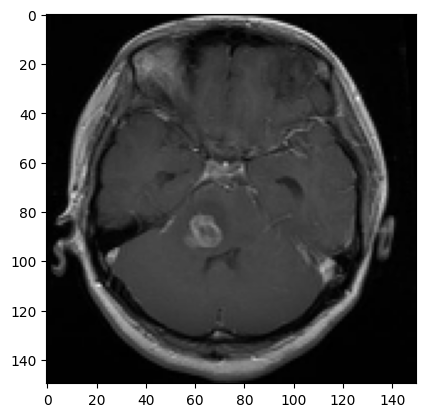

In [ ]:
plt.imshow(grey_images[20])

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 1595, 1: 1321, 2: 1339, 3: 1457}

[0 1 2 3]


<Axes: ylabel='count'>

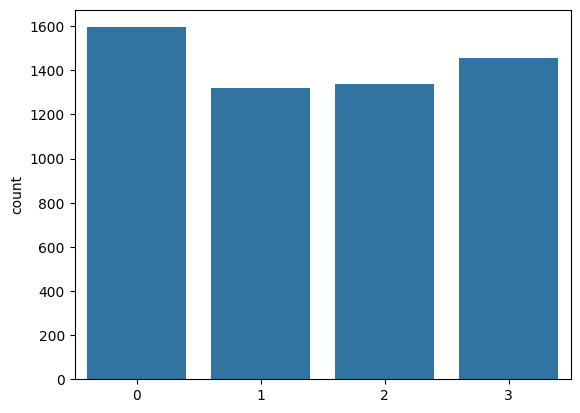

In [ ]:
import seaborn as sns
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
print(np.unique(labels))
sns.countplot(x=labels)


[0 1 2 3]


<Axes: ylabel='count'>

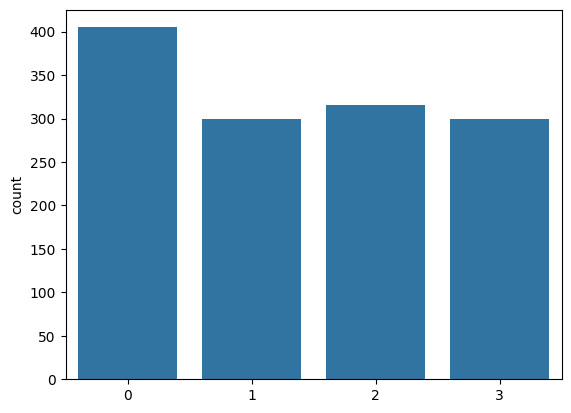

In [ ]:
grey_val_images = []
for img in images_Test:
  thresh = (img[:, :, 0]+img[:,:,1]+img[:,:,2])/3
  # Coordinates of non-black pixels.
  coords = np.argwhere(thresh > 10)

  # Bounding box of non-black pixels.
  x0, y0 = coords.min(axis=0)
  x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top

  # Get the contents of the bounding box.
  img = img[x0:x1, y0:y1]
  img = cv2.resize(img, (150, 150))
  grey_val_images.append(img)
unique, counts = np.unique(labels_Test, return_counts=True)
dict(zip(unique, counts))
import seaborn as sns
print(np.unique(labels_Test))
sns.countplot(x=labels_Test)

#Data Pre Processing

Grey Scale
Normalize the Data
Data Augmentation
Flatten the Data

In [ ]:
print (np.shape(grey_images))

(5712, 150, 150, 3)


In [ ]:
normal = []
for img in grey_images:
  img = color.rgb2gray(img)
  normal_image = (img-np.min(img))/(np.max(img)-np.min(img))
  normal.append(normal_image)

(5712, 150, 150)


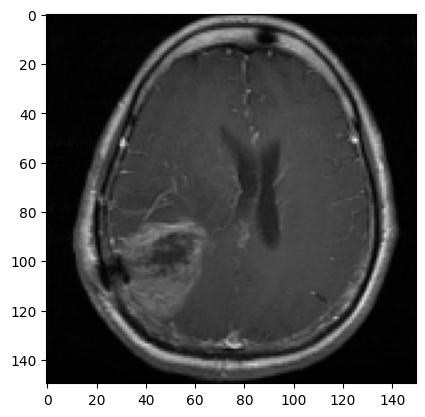

In [ ]:
plt.imshow(normal[50], cmap = 'gray' )
print(np.shape(normal))

In [ ]:
# Data Augmentation
aug_images = []
for img in normal:
  aug = np.fliplr(img)
  aug_images.append(aug)


for img in normal:
  aug_images.append(img)

aug_Labels = np.append(labels,labels)

In [ ]:
#Data Flattening for ML models
flat_images = []
for image in aug_images:
  flat_images.append(image.reshape(22500))
print(np.shape(flat_images))

(11424, 22500)


In [ ]:
normal_Val = []
for img in grey_val_images:
  img = color.rgb2gray(img)
  normal_image = (img-np.min(img))/(np.max(img)-np.min(img))
  normal_Val.append(normal_image.reshape(22500))

In [ ]:
#Data Partition
trainX, testX, trainY, testY = train_test_split(flat_images,aug_Labels,test_size = 0.2, random_state = 50)

In [ ]:
unique, counts = np.unique(trainY, return_counts=True)
dict(zip(unique, counts))

{0: 2571, 1: 2125, 2: 2123, 3: 2320}

[0 1 2 3]


<Axes: ylabel='count'>

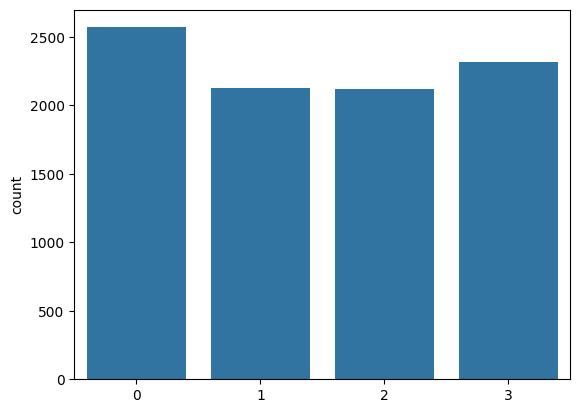

In [ ]:
print(np.unique(trainY))
sns.countplot(x=trainY)

In [ ]:
unique, counts = np.unique(testY, return_counts=True)
dict(zip(unique, counts))

{0: 619, 1: 517, 2: 555, 3: 594}

[0 1 2 3]


<Axes: ylabel='count'>

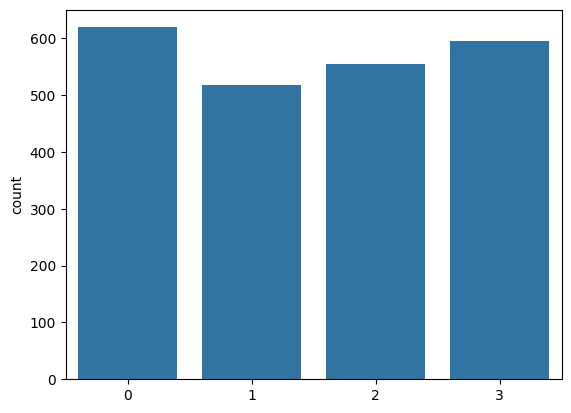

In [ ]:
print(np.unique(testY))
sns.countplot(x=testY)

# Making Models and Optimizing them

In [ ]:
# Parametric Study for KNC performance w.r.t differnt number of neighbors
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
neighbors_list = range(1,20,2)
KNC_accuracy = []
KNC_recall = []
KNC_F1 = []
for i in neighbors_list:
  classifier = KNC(n_neighbors= i)
  classifier.fit(trainX,trainY)
  y_pred = classifier.predict(testX)
  KNC_accuracy.append(accuracy_score(testY, y_pred))
  KNC_recall.append(recall_score(testY, y_pred, average='weighted'))
  KNC_F1.append(f1_score(testY, y_pred,average='weighted' ))  #run without average = weighted or look up in documentation

In [ ]:
plt.subplot(1,3,1)
plt.scatter(neighbors_list, KNC_accuracy, color = 'blue')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.subplot(1,3,2)
plt.scatter(neighbors_list, KNC_recall, color = 'red')
plt.xlabel('Number of Neighbors')
plt.ylabel('Sensitivity of detection')
plt.subplot(1,3,3)
plt.scatter(neighbors_list, KNC_F1, color = 'green')
plt.xlabel('Number of Neighbors')
plt.ylabel('F1 Score')
# HW task:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=3,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

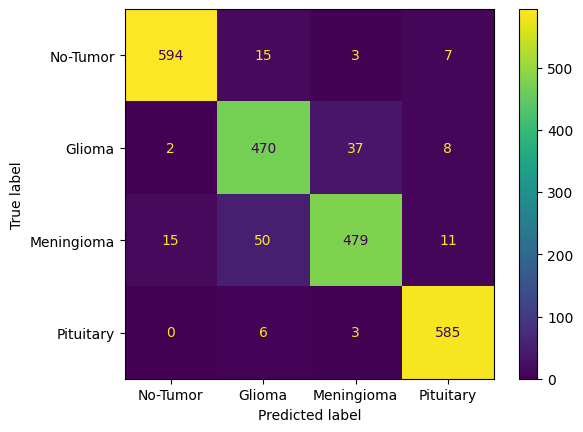

              precision    recall  f1-score   support

    No-Tumor       0.97      0.96      0.97       619
      Glioma       0.87      0.91      0.89       517
  Meningioma       0.92      0.86      0.89       555
   Pituitary       0.96      0.98      0.97       594

    accuracy                           0.93      2285
   macro avg       0.93      0.93      0.93      2285
weighted avg       0.93      0.93      0.93      2285

[3 3 2 ... 1 3 3]


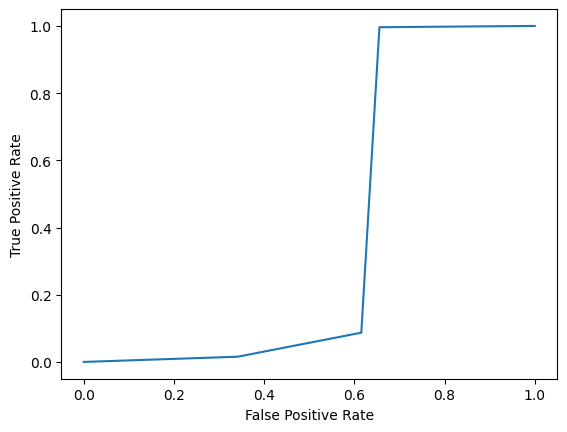

In [ ]:
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay,roc_curve,RocCurveDisplay
KNCclassifier = KNC(n_neighbors = 1)
KNCclassifier.fit(trainX,trainY)
y_pred = KNCclassifier.predict(testX)
cm_knc= confusion_matrix(testY,y_pred, labels=KNCclassifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knc,display_labels=classes)
disp.plot()
plt.show()
cr_knc = classification_report(testY, y_pred,
	target_names=classes)
print(cr_knc)
print(y_pred)
#PrecisionRecallDisplay.from_predictions(testY, y_pred)
#plt.show()
fpr, tpr, _ = roc_curve(testY, y_pred, pos_label=KNCclassifier.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

In [ ]:
Exporting the model to be used in the web application
from joblib import dump
%cd ../../
#dump(KNCclassifier, "KNCC.joblib")

/content/gdrive/MyDrive


In [ ]:
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
KNCclassifier = KNC(n_neighbors = 1)
KNCclassifier.fit(trainX,trainY)
y_pred = KNCclassifier.predict(testX)
cm = confusion_matrix(testY, y_pred)
print(cm)
print(classification_report(testY, y_pred,
	target_names=classes))
print(testY)

[[594  15   3   7]
 [  2 470  37   8]
 [ 15  50 479  11]
 [  0   6   3 585]]
              precision    recall  f1-score   support

    No-Tumor       0.97      0.96      0.97       619
      Glioma       0.87      0.91      0.89       517
  Meningioma       0.92      0.86      0.89       555
   Pituitary       0.96      0.98      0.97       594

    accuracy                           0.93      2285
   macro avg       0.93      0.93      0.93      2285
weighted avg       0.93      0.93      0.93      2285

[3 3 2 ... 1 3 3]


(1321, 22500)
(1321,)
[[396   6   1   2]
 [  1 270  22   7]
 [  5  22 285   4]
 [  0   1   0 299]]
              precision    recall  f1-score   support

    No-Tumor       0.99      0.98      0.98       405
      Glioma       0.90      0.90      0.90       300
  Meningioma       0.93      0.90      0.91       316
   Pituitary       0.96      1.00      0.98       300

    accuracy                           0.95      1321
   macro avg       0.94      0.94      0.94      1321
weighted avg       0.95      0.95      0.95      1321

[3 3 2 ... 1 3 3]


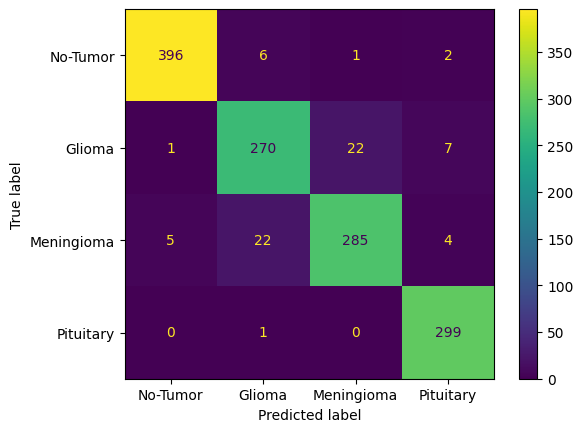

In [ ]:
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
y_pred = KNCclassifier.predict(normal_Val)
print(np.shape(normal_Val))
print(np.shape(labels_Test))
cm = confusion_matrix(labels_Test, y_pred)
print(cm)
print(classification_report(labels_Test, y_pred,
	target_names=classes))
print(testY)
cm_knc= confusion_matrix(labels_Test,y_pred, labels=KNCclassifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knc,display_labels=classes)
disp.plot()
plt.show()

In [ ]:
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
KNCclassifier = KNC(n_neighbors = 3)
KNCclassifier.fit(trainX,trainY)
y_pred = KNCclassifier.predict(testX)
cm = confusion_matrix(testY, y_pred)
print(cm)
print(classification_report(testY, y_pred,
	target_names=classes))
print(testY)

[[568  29  10  12]
 [  2 454  50  11]
 [ 24  87 417  27]
 [  0   9   5 580]]
              precision    recall  f1-score   support

    No-Tumor       0.96      0.92      0.94       619
      Glioma       0.78      0.88      0.83       517
  Meningioma       0.87      0.75      0.80       555
   Pituitary       0.92      0.98      0.95       594

    accuracy                           0.88      2285
   macro avg       0.88      0.88      0.88      2285
weighted avg       0.89      0.88      0.88      2285

[3 3 2 ... 1 3 3]


[[421  59 125  14]
 [  4 428  54  31]
 [ 65 254 184  52]
 [  2 112 104 376]]
              precision    recall  f1-score   support

    No-Tumor       0.86      0.68      0.76       619
      Glioma       0.50      0.83      0.62       517
  Meningioma       0.39      0.33      0.36       555
   Pituitary       0.79      0.63      0.70       594

    accuracy                           0.62      2285
   macro avg       0.64      0.62      0.61      2285
weighted avg       0.65      0.62      0.62      2285



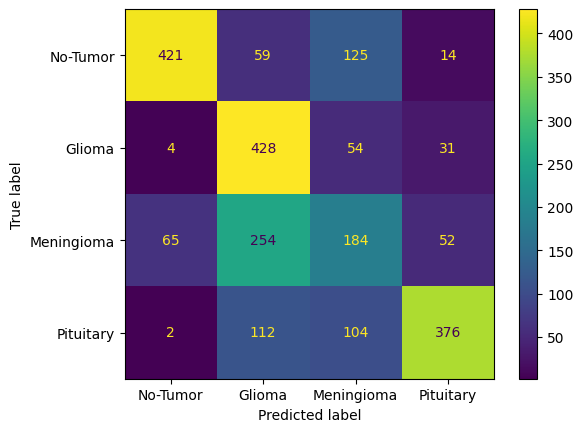

In [ ]:
# Naive Bayes Classifier
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
NBclassifier = GaussianNB();
NBclassifier.fit(trainX, trainY)

# predicting test set results
y_pred = NBclassifier.predict(testX)

# making the confusion matrix
cm = confusion_matrix(testY, y_pred)
print(cm)
print(classification_report(testY, y_pred,
	target_names=classes))
cm_nb= confusion_matrix(testY,y_pred, labels=NBclassifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb,display_labels=classes)
disp.plot()
plt.show()

In [ ]:
dump(NBclassifier, "NBC.joblib")

['NBC.joblib']

In [ ]:
!pip install XGboost
import xgboost as xgb

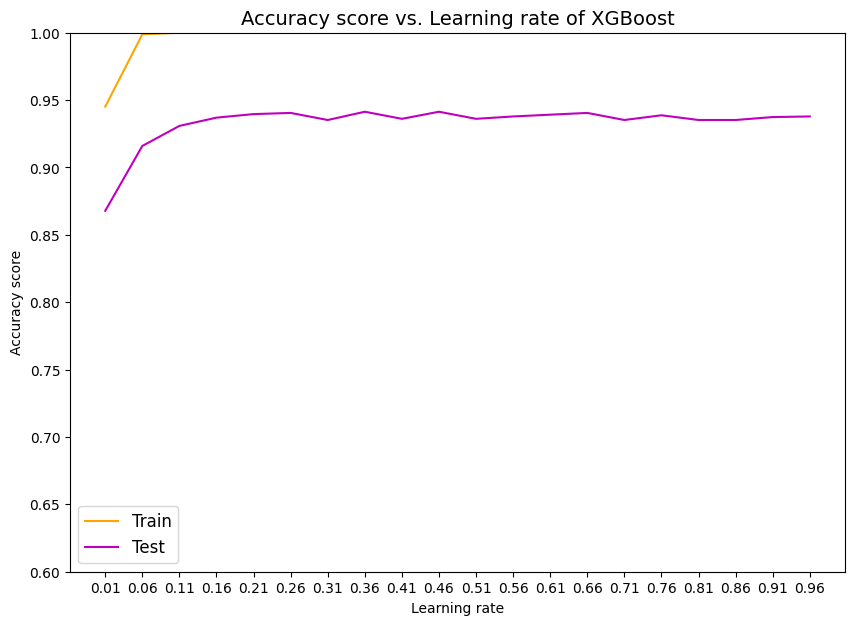

In [ ]:
# XGBoost (different learning rate)
#Try to optimitze the algorithm using max_depth function
classes = ['Glioma', 'Meningioma',  'No-Tumor', 'Pituitary']
learning_rate_range = np.arange(0.01, 1, 0.05)
test_XG = []
train_XG = []
for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr, objective = 'multiclass')
    xgb_classifier.fit(trainX, trainY)
    train_XG.append(xgb_classifier.score(trainX, trainY))
    test_XG.append(xgb_classifier.score(testX, testY))
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

[3 3 0 ... 1 3 3] [[8.5437860e-06 2.5411530e-06 2.0256671e-04 9.9978632e-01]
 [1.2863196e-04 1.8835539e-02 4.7176862e-03 9.7631806e-01]
 [9.8753464e-01 2.2793048e-04 1.2229764e-02 7.6555916e-06]
 ...
 [3.3743721e-03 9.8622745e-01 3.6216236e-03 6.7764777e-03]
 [2.3773632e-06 1.2748850e-05 2.3386861e-05 9.9996150e-01]
 [6.0233833e-06 3.6386846e-05 1.3378386e-03 9.9861979e-01]]
[[612   2   2   3]
 [  2 467  45   3]
 [ 43  15 475  22]
 [  1   2   7 584]]
              precision    recall  f1-score   support

    No-Tumor       0.93      0.99      0.96       619
      Glioma       0.96      0.90      0.93       517
  Meningioma       0.90      0.86      0.88       555
   Pituitary       0.95      0.98      0.97       594

    accuracy                           0.94      2285
   macro avg       0.94      0.93      0.93      2285
weighted avg       0.94      0.94      0.93      2285



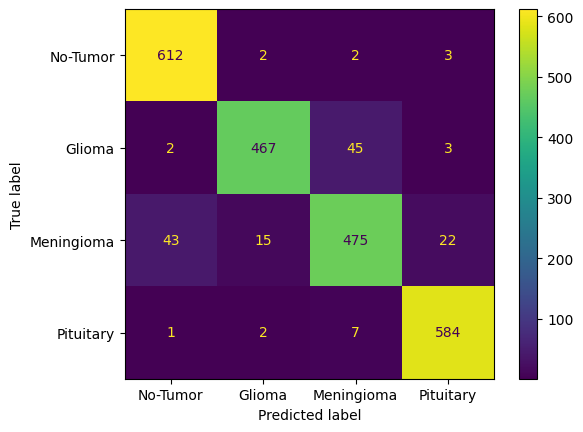

In [ ]:
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
xgb_classifier = xgb.XGBClassifier(eta = 0.41, objective='multi:softmax',
                            num_class=3,
                            missing=1,
#                            early_stopping_rounds=10,
#                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_classifier.fit(trainX, trainY)
y_pred = xgb_classifier.predict(testX)
y_pred_prob = xgb_classifier.predict_proba(testX)
print(y_pred,y_pred_prob)
cm = confusion_matrix(testY, y_pred)
print(cm)
print(classification_report(testY, y_pred,
	target_names=classes))
cm_xgb= confusion_matrix(testY,y_pred, labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,display_labels=classes)
disp.plot()
plt.show()

In [ ]:
dump(xgb_classifier, "XGBC.joblib")

['XGBC.joblib']

In [ ]:
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
estimators_list = range(10,200,20)
RF_accuracy = []
RF_recall = []
RF_F1 = []
for i in estimators_list:
  RF = RandomForestClassifier(n_estimators=i, random_state=42)
  RF.fit(trainX, trainY)
  y_pred = RF.predict(testX)
  RF_accuracy.append(accuracy_score(testY, y_pred))
  RF_recall.append(recall_score(testY, y_pred, average= 'weighted'))
  RF_F1.append(f1_score(testY, y_pred, average='weighted'))

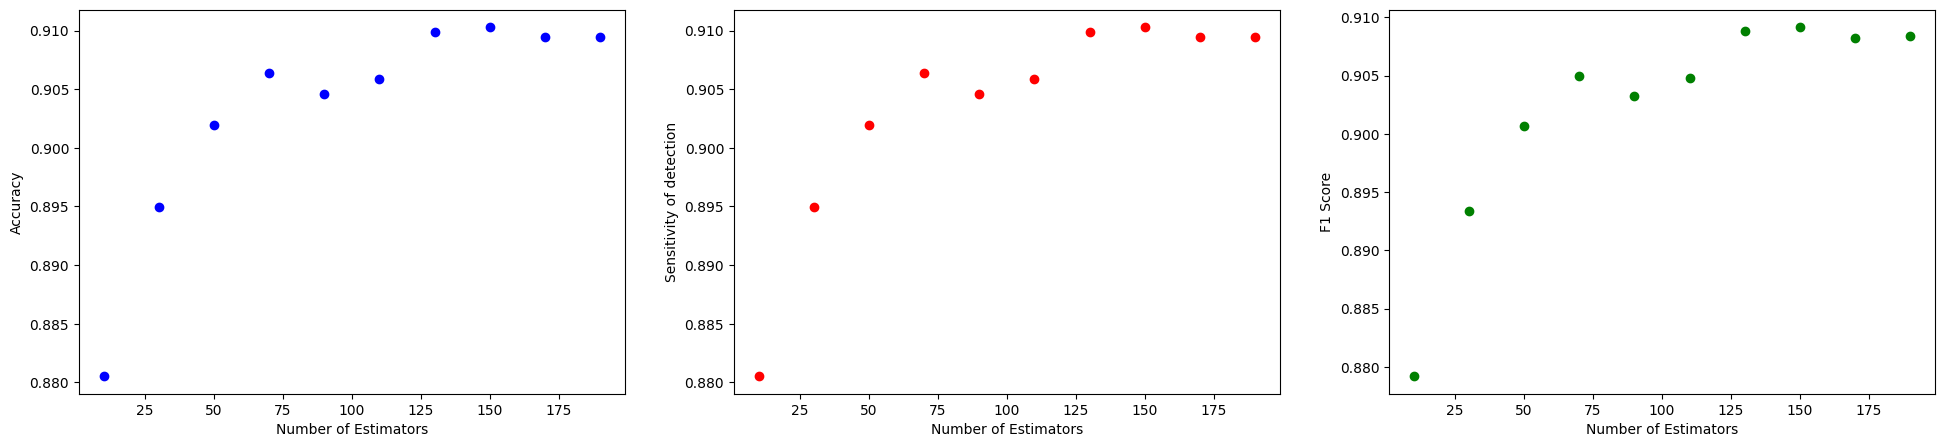

In [ ]:
plt.subplot(1,3,1)
plt.scatter(estimators_list, RF_accuracy, color = 'blue')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.subplot(1,3,2)
plt.scatter(estimators_list, RF_recall, color = 'red')
plt.xlabel('Number of Estimators')
plt.ylabel('Sensitivity of detection')
plt.subplot(1,3,3)
plt.scatter(estimators_list, RF_F1, color = 'green')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=3,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

#Feature Selection
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-faces-py

[[609   3   5   2]
 [  0 433  74  10]
 [ 39  20 458  38]
 [  1   4  10 579]]
              precision    recall  f1-score   support

    No-Tumor       0.94      0.98      0.96       619
      Glioma       0.94      0.84      0.89       517
  Meningioma       0.84      0.83      0.83       555
   Pituitary       0.92      0.97      0.95       594

    accuracy                           0.91      2285
   macro avg       0.91      0.91      0.91      2285
weighted avg       0.91      0.91      0.91      2285



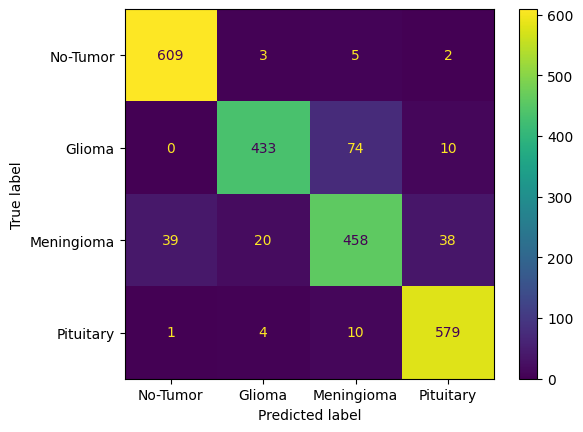

In [ ]:
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
RFclassifier = RandomForestClassifier(n_estimators=130, random_state=42)
RFclassifier.fit(trainX, trainY)
y_pred = RFclassifier.predict(testX)
cm = confusion_matrix(testY, y_pred)
print(cm)
print(classification_report(testY, y_pred,
	target_names=classes))
cm_RF= confusion_matrix(testY,y_pred, labels=RFclassifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF,display_labels=classes)
disp.plot()
plt.show()


In [ ]:
dump(RFclassifier, "RFC.joblib")

['RFC.joblib']

[[404   1   0   0]
 [  0 237  54   9]
 [ 24  15 265  12]
 [  0   3   3 294]]
              precision    recall  f1-score   support

    No-Tumor       0.94      1.00      0.97       405
      Glioma       0.93      0.79      0.85       300
  Meningioma       0.82      0.84      0.83       316
   Pituitary       0.93      0.98      0.96       300

    accuracy                           0.91      1321
   macro avg       0.91      0.90      0.90      1321
weighted avg       0.91      0.91      0.91      1321



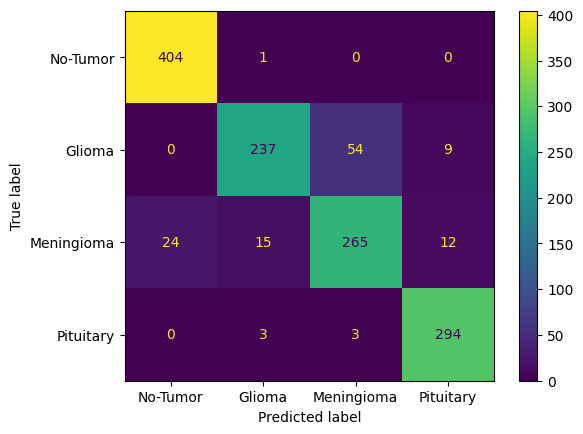

In [ ]:
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
y_val_pred = RFclassifier.predict(normal_Val)
cm = confusion_matrix(labels_Test, y_val_pred)
print(cm)
print(classification_report(labels_Test, y_val_pred,
	target_names=classes))
cm_RF= confusion_matrix(labels_Test,y_val_pred, labels=RFclassifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF,display_labels=classes)
disp.plot()
plt.show()


[ 8898 20237  1188  1814  1362   613 20560 22350 22498]


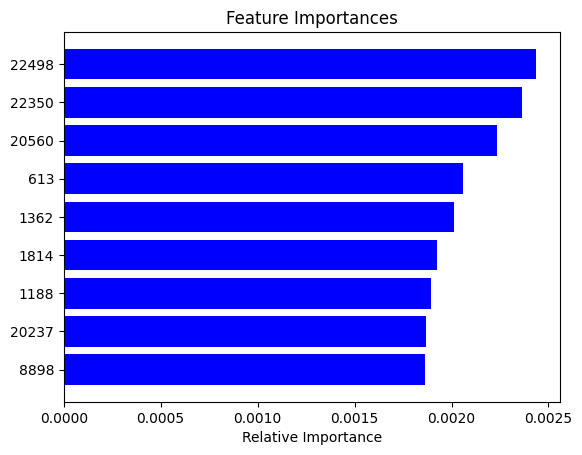

In [ ]:
# Pixel Importance
importances = RF.feature_importances_
indices = np.argsort(importances)
top10 = []
top10 = indices[22491:22500]
print (top10)
features = []
features = trainX
plt.title('Feature Importances')
plt.barh(range(len(top10)), importances[top10], color='b', align='center')
plt.yticks(range(len(top10)),[i for i in top10])
plt.xlabel('Relative Importance')
plt.show()

Elapsed time to compute the importances: 0.090 seconds 1


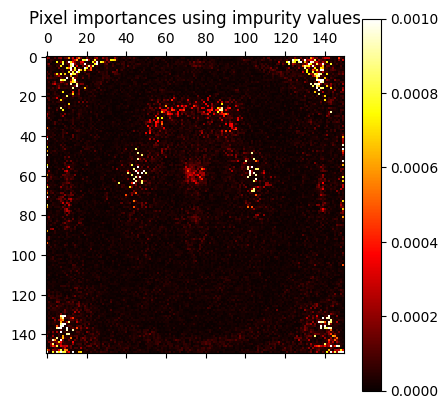

Elapsed time to compute the importances: 0.035 seconds 0


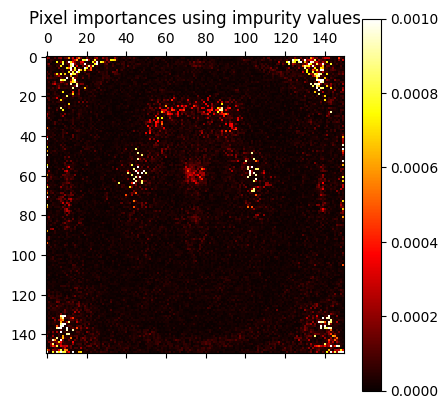

In [ ]:
import time

import matplotlib.pyplot as plt

start_time = time.time()
img_shape = aug_images[309].shape
importances = RF.feature_importances_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds {labels[309]}")
imp_reshaped = importances.reshape(img_shape)
plt.matshow(imp_reshaped, cmap=plt.cm.hot)
plt.title("Pixel importances using impurity values")
plt.colorbar()
plt.clim(0,0.001)#change the scaling of the color bar so that anything above 0.003 is very apparent as white
plt.show()
start_time = time.time()
img_shape = aug_images[309].shape
importances = RF.feature_importances_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds {labels[2309]}")
imp_reshaped = importances.reshape(img_shape)
plt.matshow(imp_reshaped, cmap=plt.cm.hot)
plt.title("Pixel importances using impurity values")
plt.colorbar()
plt.clim(0,0.001)#change the scaling of the color bar so that anything above 0.003 is very apparent as white
plt.show()

In [ ]:
importances = xgb_classifier.feature_importances_
indices = np.argsort(importances)
top10 = []
top10 = indices[22401:22500]
print (top10)
features = []
features = trainX
plt.title('Feature Importances of XGBoost Classifier')
plt.bar(range(len(top10)), importances[top10], color='b', align='center')
plt.xticks(range(len(top10)),[i for i in top10])
plt.xlabel('Relative Importance')
plt.show()
start_time = time.time()
img_shape = aug_images[309].shape
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
imp_reshaped = importances.reshape(img_shape)
plt.matshow(imp_reshaped, cmap=plt.cm.hot)
plt.title("Pixel importances using impurity values (XGB)")
plt.colorbar()
plt.clim(0,0.005)#change the scaling of the color bar so that anything above 0.003 is very apparent as white
plt.show()

#Neural Networks


In [ ]:
layers = [(10), (10, 10), (10, 10, 10), (100), (100, 100), (100,100, 100), (500), (500, 500), (500, 500, 500)]#add more to this
acc = []
for i in layers:
  MLP = MLPClassifier(hidden_layer_sizes = i, random_state= 42)
  MLP.fit(trainX, trainY)
  y_pred = MLP.predict(testX)
  a = accuracy_score(testY, y_pred)
  acc.append(a)
  print('For layers'+ str(i) + 'accuracy is' + str(a))
  #cm = confusion_matrix(testY, y_pred)
  #print(cm)



In [ ]:
layers = [(100)]#add more to this
acc = []
for i in layers:
  MLP = MLPClassifier(hidden_layer_sizes = i, solver = 'sgd', learning_rate = 'adaptive', random_state= 42)
  MLP.fit(trainX, trainY)
  y_pred = MLP.predict(testX)
  a = accuracy_score(testY, y_pred)
  acc.append(a)
  print('For layers'+ str(i) + 'accuracy is' + str(a))
  #cm = confusion_matrix(testY, y_pred)
  #print(cm)


For layers100accuracy is0.8936542669584245


In [ ]:
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
print(classification_report(testY, y_pred,
	target_names=classes))

              precision    recall  f1-score   support

    No-Tumor       0.94      0.95      0.94       619
      Glioma       0.84      0.85      0.85       517
  Meningioma       0.85      0.79      0.82       555
   Pituitary       0.93      0.97      0.95       594

    accuracy                           0.89      2285
   macro avg       0.89      0.89      0.89      2285
weighted avg       0.89      0.89      0.89      2285



## Tensor Flow
https://www.tensorflow.org/tutorials/images/cnn


In [ ]:
#using 2d images for tensorflow
Xtrain_tf, Xtest_tf, ytrain_tf, ytest_tf = train_test_split(aug_images,aug_Labels,test_size = 0.2, random_state = 50)
print(np.shape(ytrain_tf))
print(np.shape(Xtrain_tf))

(9139,)
(9139, 150, 150)


In [ ]:
def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  # i'm sorry for this function's code. i am so sorry.
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
  ax.legend(loc = 1)
  ax.set_ylim([0.01, 1])

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')

  plt.show()

In [ ]:
import tensorflow as tf
# Define the model
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150,1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(Xtrain_tf, ytrain_tf, epochs=10)

# Evaluate the model
model.evaluate(Xtest_tf, ytest_tf)

In [ ]:
!pip install tf-keras-vis tensorflow

import tensorflow as tf
import tensorflow.keras as keras
from tf_keras_vis.saliency import Saliency
from tf_keras_vis import utils as utils
from tf_keras_vis.utils import normalize
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

In [ ]:
from keras.applications.vgg16 import VGG16
from keras import layers
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from PIL import Image
import keras
scaled_images = []
#for img in image_data:
#  image = Image.fromarray(img)
#  scaled_images.append(image.resize((224, 224), Image.BILINEAR))
Xtrain_Vgg, Xtest_Vgg, ytrain_Vgg, ytest_Vgg = train_test_split(aug_images,aug_Labels,test_size = 0.2, random_state = 50)
print(np.shape(ytrain_Vgg))
ytrain_Vgg = np.reshape(ytrain_Vgg,[9139,1])
## Resizing images
Xtrain_Vgg = tf.image.resize(Xtrain_Vgg, (150, 150))
Xtest_Vgg = tf.image.resize(Xtest_Vgg, (150, 150))
print(np.shape(ytrain_Vgg))
print(np.shape(Xtrain_Vgg))
## Transforming labels to correct format
ytrain_Vgg = to_categorical(ytrain_Vgg, num_classes=4)
ytest_Vgg = to_categorical(ytest_Vgg, num_classes=4)
# Defining Model
base_model = VGG16(input_shape=Xtrain_Vgg[0].shape,
                   include_top=False,
                   weights="imagenet")
# Freezing Layers
for layer in base_model.layers:
    layer.trainable=False
## Preprocessing input
Xtrain_Vgg = preprocess_input(Xtrain_Vgg)
Xtest_Vgg = preprocess_input(Xtest_Vgg)
# Summary
base_model.summary()
#model = VGG16()
#print(model.summary())
#NUM_CLASSES = 1
#model.layers[0].trainable = False
#model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False), metrics=["accuracy"])
#model.summary()

(9139,)
(9139, 1)
(9139, 150, 150, 3)
58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                        

In [ ]:
from tensorflow.keras import layers, models
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit(Xtrain_Vgg, ytrain_Vgg, epochs=5, validation_split=0.2, batch_size=32, callbacks=[es])

In [ ]:
from tensorflow.keras import layers, models
dropout_layer = Dropout(0.2)
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')


model = models.Sequential([
    base_model,
    dropout_layer,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])
# Model Compile
OPT = tf.keras.optimizers.Adam(learning_rate=0.001)
#model.compile(loss='binary_crossentropy',
#              metrics=[tf.keras.metrics.AUC(name = 'auc')],
#              optimizer=OPT)
model.compile(
    optimizer=OPT,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model_history = model.fit(Xtrain_Vgg, ytrain_Vgg, epochs=1, validation_split = 0.2, batch_size=32, callbacks=[es])

229/229 [==============================] - 32s 112ms/step - loss: 1.2484 - accuracy: 0.3802 - val_loss: 1.1284 - val_accuracy: 0.4743


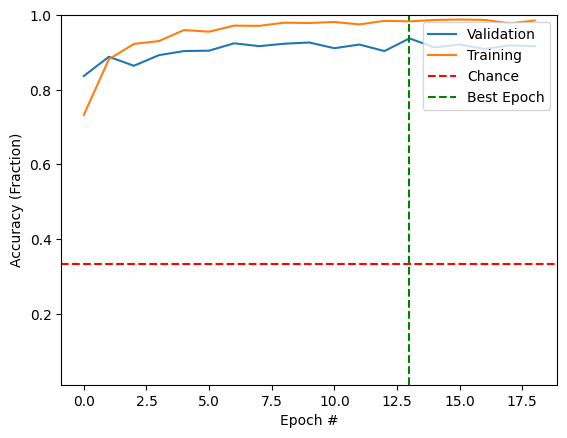

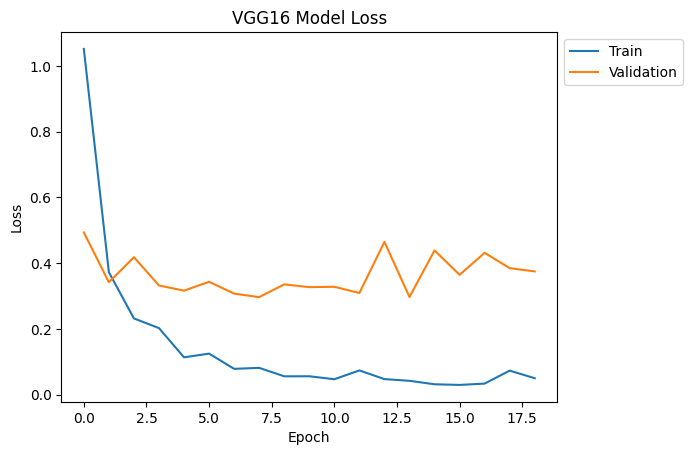

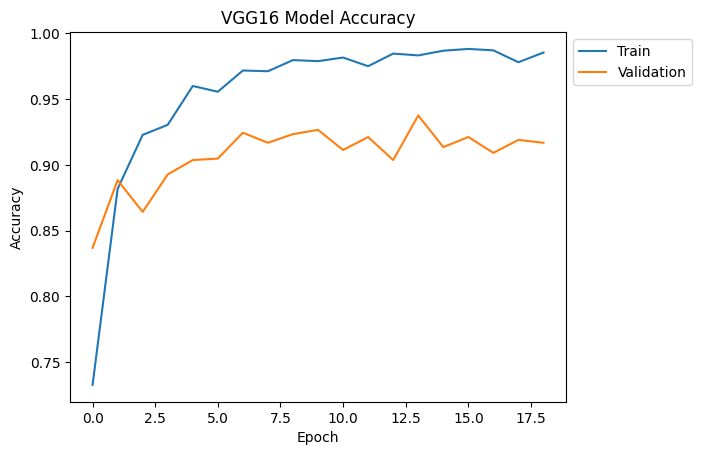

In [ ]:
plot_acc(model_history)
# Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()
# Summarize models auc

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('VGG16 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
def extract_vector_vgg(data_holder):

    vgg_feature_list = []

    for im in data_holder:

        im = image.img_to_array(im)

        img = preprocess_input(np.expand_dims(im.copy(), axis=0))

        vgg_feature = base_model.predict(img)

        vgg_feature_np = np.array(vgg_feature)

        vgg_feature_list.append(vgg_feature_np.flatten())
    return np.array(vgg_feature_list)

In [ ]:
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
neighbors_list = range(1,11,2)
KNCF_accuracy = []
KNCF_recall = []
KNCF_F1 = []
#Xtrain_Vgg, Xtest_Vgg, ytrain_Vgg, ytest_Vgg = train_test_split(aug_images1,aug_Labels,test_size = 0.2, random_state = 50)
#ytrain_Vgg = np.reshape(ytrain_Vgg,[404,1])
#ytest_Vgg = np.reshape(ytest_Vgg,[102,1])
array = extract_vector_vgg(Xtrain_Vgg)
array1 = extract_vector_vgg(Xtest_Vgg)
for i in neighbors_list:
    KNCFclassifier = KNC(n_neighbors=i)
    KNCFclassifier.fit(array,ytrain_Vgg)
    y_pred = KNCFclassifier.predict(array1)
    KNCF_accuracy.append(accuracy_score(ytest_Vgg, y_pred))
    KNCF_recall.append(recall_score(ytest_Vgg,y_pred,average="weighted"))
    KNCF_F1.append(f1_score(ytest_Vgg, y_pred, average="weighted"))

KNCFclassifier = KNC(n_neighbors=1)
KNCFclassifier.fit(array,ytrain_Vgg)
ypred = KNCFclassifier.predict(array1)
y_pred = np.argmax(ypred, axis=1)
true_classes = np.argmax(ytest_Vgg, axis=1)
import sklearn
#sklearn.preprocessing.LabelBinarizer(y_pred)
cr_kncf = classification_report(true_classes, y_pred, target_names=classes)
#cm_kncf = confusion_matrix(ytest_Vgg, y_pred)
cm_kncf= confusion_matrix(true_classes,y_pred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_kncf,display_labels=classes)
disp.plot()
plt.show()

              precision    recall  f1-score   support

    No-Tumor       0.98      0.98      0.98       619
      Glioma       0.91      0.88      0.89       517
  Meningioma       0.88      0.86      0.87       555
   Pituitary       0.93      0.98      0.95       594

    accuracy                           0.93      2285
   macro avg       0.92      0.92      0.92      2285
weighted avg       0.93      0.93      0.93      2285



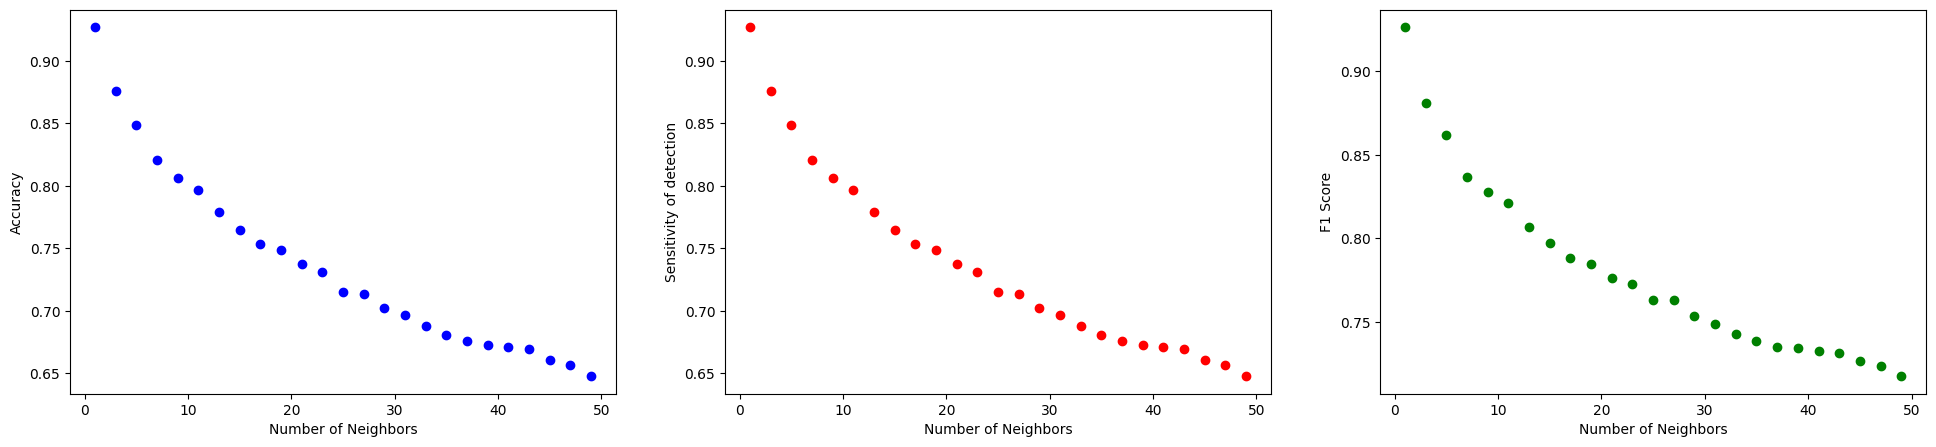

In [ ]:
print (cr_kncf)
plt.subplot(1,3,1)
plt.scatter(neighbors_list, KNCF_accuracy, color = 'blue')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.subplot(1,3,2)
plt.scatter(neighbors_list, KNCF_recall, color = 'red')
plt.xlabel('Number of Neighbors')
plt.ylabel('Sensitivity of detection')
plt.subplot(1,3,3)
plt.scatter(neighbors_list, KNCF_F1, color = 'green')
plt.xlabel('Number of Neighbors')
plt.ylabel('F1 Score')
# HW task:
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=3,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)

In [ ]:
dump(KNCFclassifier, "KNCF.joblib")

['KNCF.joblib']

In [ ]:
model.fit(Xtrain_Vgg, ytrain_Vgg, epochs=5, validation_split = 0.2, batch_size=32, callbacks=[es])
classes = ['No-Tumor','Glioma', 'Meningioma', 'Pituitary']
ypred = model.predict(Xtest_Vgg)
y_pred = np.argmax(ypred, axis=1)
true_classes = np.argmax(ytest_Vgg, axis=1)
print(confusion_matrix(true_classes, y_pred))
report = classification_report(true_classes, y_pred, target_names=classes)
print(report)
cm_VGG= confusion_matrix(true_classes,y_pred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_VGG,display_labels=classes)
disp.plot()
plt.show()

In [ ]:
dump(model, "Vgg16C.joblib")

['Vgg16C.joblib']